# Mountain detection

In this notebook we'll build a model to recognise the mountain names in the texts.

Let's get sarted!

In [42]:
# We'll use this module to save tokenized and labeled dataset
!pip install fastparquet

## Import libraries

In [43]:
%matplotlib inline

import os
import re
import spacy
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import precision_recall_curve, auc
from torch import nn
from torchtext.vocab import build_vocab_from_iterator
import gensim.downloader
from gensim.models import Word2Vec
import string

In [44]:
global_device = 'cpu'

if torch.cuda.is_available():
    global_device = 'cuda'

DATA_DIR = "/kaggle/input/mountain-ner-dataset/"

## Load data

In [45]:
mountain_dataset = pd.read_csv(DATA_DIR + "mountain_dataset_with_markup.csv", converters={'marker': eval})


In [46]:
mountain_dataset.head()

,text,marker
0,A visit to a science museum for hands-on learn...,[]
1,Voice surface coach set democratic time year. ...,[]
2,Parent according maybe activity activity finis...,[]
3,A visit to a sculpture garden with intriguing ...,[]
4,The Julian Alps in Slovenia offer pristine lak...,"[(11, 15)]"


## A bit of EDA

First of all let's divide each marker of a mountain name, that consists of more than one word, into separate markers. We will need such approach for the next section, yet I'd like to do this process now, so while exploring the data we will be already keeping in mind that the markers are divided 

In [47]:
def divide_markers(text, markers):
    divided_markers = []
    
    for start, end in markers:
        # Extract the mountain name from the text based on the marker
        mountain_name = text[start:end]

        # Split the mountain name into individual words
        words = mountain_name.split(" ")

        # Generate divided markers for each word
        for word in words:
            word_start = text.find(word, start)
            word_end = word_start + len(word)
            divided_markers.append((word_start, word_end))

    return divided_markers


# Apply the divide_markers function to the DataFrame
mountain_dataset['markers'] = mountain_dataset.apply(lambda row: divide_markers(row['text'], row['marker']), axis=1)

In [48]:
mountain_dataset['mountain_count'] = mountain_dataset['markers'].apply(len)

In [49]:
def get_mountains(row):
    text, loc_markers = row['text'], row['markers']
    return [text[s:e] for s, e in loc_markers]

print(mountain_dataset[mountain_dataset['mountain_count'] >= 1].iloc[1]['text'])
print(get_mountains(mountain_dataset[mountain_dataset['mountain_count'] >= 1].iloc[1]))

The Dolomites in Italy are famous for their unique limestone formations.
['Dolomites']


In [50]:
mountain_dataset.shape[0]

1584

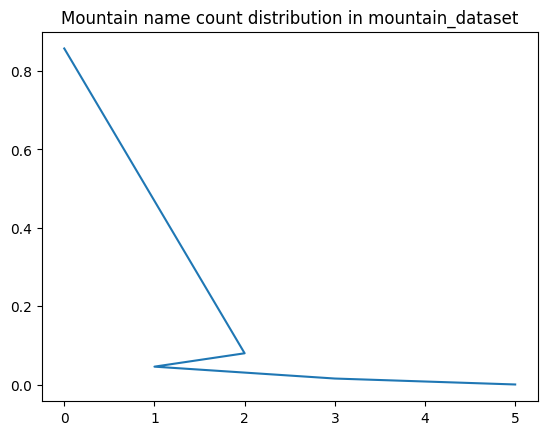

mountain_count
0    1358
2     127
1      73
3      25
5       1
Name: count, dtype: int64


In [51]:
plt.title('Mountain name count distribution in mountain_dataset')
plt.plot(mountain_dataset['mountain_count'].value_counts(normalize=True))

plt.show()

print(mountain_dataset['mountain_count'].value_counts())

In [52]:
mountains = mountain_dataset.apply(get_mountains, axis=1)

result = []
for x in mountains.to_list():
    for l in x:
        result.append(l)

pd.Series(result).value_counts()

Mountains       82
Mount           45
Alps            34
Andes           23
Himalayas       19
Taurus          12
Range           12
Rhodope          9
Everest          9
Rocky            8
Appalachian      8
Fuji             7
Shan             7
Kilimanjaro      7
Scandinavian     7
Rainier          5
Sierra           5
Olympus          5
Denali           5
Kunlun           5
Dividing         4
Atlas            4
Patagonian       4
Drakensberg      4
Great            4
Brooks           4
Carpathian       4
Tien             4
Blue             4
Cascade          4
Ridge            4
Tatra            4
Tian             3
Cook             3
Apennine         3
Dolomites        3
Ural             3
Elbrus           3
mountains        3
Nevada           3
Rwenzori         3
Kenya            2
Columbia         2
St.              2
Occidental       2
Madre            2
Helens           2
Icefield         2
K2               1
Dolomite         1
Logan            1
Eiger            1
Name: count,

## Preparation for Evaluation of our model

In [53]:
def process_text(text):
    text = re.sub(r'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower()

def metric(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([process_text(s) for s in y_true_sample])
        y_pred_sample = set([process_text(s) for s in y_pred_sample])

        tp += len(y_true_sample & y_pred_sample)
        fp += len(y_pred_sample - y_true_sample)
        fn += len(y_true_sample - y_pred_sample)
        p += len(y_true_sample)

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)

    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp+fn)

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2*precision*recall/(precision+recall)
        
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Data preparation

Naw we'll get our dataset to CoNLL format. 

We want to convert our dataset to CONLL BIO tagging as following

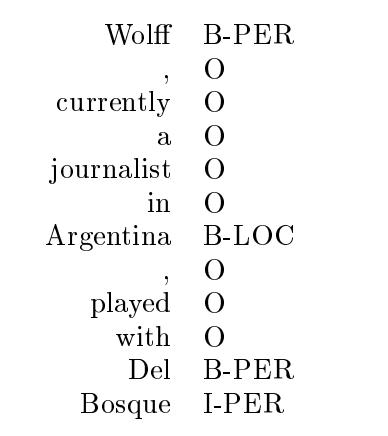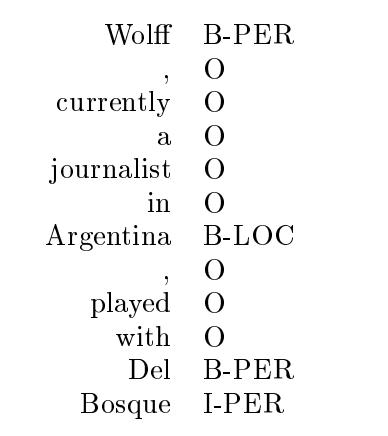

To mark mountain using two tokens: begining of mountain/location name (B-LOC) and inside of mountain/location name (I-LOC).

This is necesary, because with using only one LOC token two different mountain names and the one name with two words in it would look the same.

In [54]:
# As the language of the texts is english we'll use en_core_web_sm tokenizer
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner', 'texcat'])

def tokenize(texts, all_texts_loc_markers, tokenizer, batch_size=128, n_process=-1):
    all_texts_tokenized = list(tokenizer.pipe(texts, batch_size=batch_size, n_process=n_process))

    result_tokens = []
    result_labels = []
    for tokenized_text, loc_markers in zip(all_texts_tokenized, all_texts_loc_markers):
        tokens = [token.text for token in tokenized_text]
        labels = ['O'] * len(tokenized_text)

        for idx, token in enumerate(tokenized_text):
            for start, end in loc_markers:
                if token.idx >= start and token.idx + len(token.text) <= end:
                    if token.idx == start:
                        # If token start pos == marker start,
                        # then it is begining of new mountain name
                        labels[idx] = 'B-LOC'
                    else:
                        # If token start pos > marker start,
                        # then it is inside of mountain name
                        labels[idx] = 'I-LOC'
        result_tokens.append(tokens)
        result_labels.append(labels)
        
    return result_tokens, result_labels

In [55]:
def process_dataset(dataset, result_path, n_splits=100):
    try:
        os.remove(result_path)
    except OSError:
        pass
    
    for split in tqdm(np.array_split(dataset, n_splits), total=n_splits, bar_format='{l_bar}{bar:100}{r_bar}'):
        tokens, labels = tokenize(split['text'].to_list(), split['markers'].to_list(), nlp)
        result_df = pd.DataFrame({'tokens': tokens, 'labels': labels})
        if not os.path.isfile(result_path):
            result_df.to_parquet(result_path, engine='fastparquet')
        else:
            result_df.to_parquet(result_path, engine='fastparquet', append=True)

In [56]:
process_dataset(mountain_dataset, 'mountain_dataset_processed.parquet')
del mountain_dataset

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|                                                                                                    | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
  1%|█                                                                                                   | 1/100 [00:00<00:19,  5.19it/s]/opt/conda/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. C

In [57]:
processed_dataset = pd.read_parquet('mountain_dataset_processed.parquet', engine='fastparquet')

In [58]:
processed_dataset[10:20]

,tokens,labels
10,"[Ten, be, ten, cover, use, meeting, ., Season,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
11,"[Manage, trade, stand, site, fund, administrat...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
12,"[Care, energy, fast, almost, player, source, ....","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
13,"[The, Dolomites, in, Italy, are, famous, for, ...","[O, B-LOC, O, O, O, O, O, O, O, O, O, O]"
14,"[Civil, film, yet, turn, top, ., Event, struct...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
15,"[A, visit, to, an, astronomy, observatory, for...","[O, O, O, O, O, O, O, O, O]"
16,"[Small, share, Congress, study, standard, issu...","[O, O, O, O, O, O, O, O, O, O, O, O, O]"
17,"[Career, forget, too, wrong, similar, address,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
18,"[Fear, hour, but, president, ., Plan, professi...","[O, O, O, O, O, O, O, O, O, O, O, O, O]"
19,"[Sampling, local, coffee, shops, and, their, u...","[O, O, O, O, O, O, O, O, O]"


### Cross validations

Split dataset into train, test and validation.


In [59]:
train_processed_dataset, holdout_processed_dataset = (
    processed_dataset[processed_dataset.index < 1400].reset_index(drop=True),
    processed_dataset[processed_dataset.index >= 1400].reset_index(drop=True)
)
len(train_processed_dataset), len(holdout_processed_dataset)

(1400, 184)

In [60]:
def count_montains(labels):
    names = [1 for label in labels if label == 'B-LOC']
    return len(names)

In [61]:
train_processed_dataset['mountain_count'] = train_processed_dataset['labels'].apply(count_montains)
train_processed_dataset['stratify_col'] = train_processed_dataset['mountain_count']
train_processed_dataset.loc[train_processed_dataset['mountain_count'] >= 10, 'stratify_col'] = -1

In [62]:
skf = StratifiedKFold(n_splits=4, shuffle=True)
# gkf = GroupKFold(n_splits=4)
train_test_ids = [fold for fold in skf.split(train_processed_dataset, train_processed_dataset['stratify_col'])]

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


### Torch dataset

Training  Word2Vec embeddor for the model

In [63]:
sentences = train_processed_dataset['tokens'].to_numpy()

embeddor = Word2Vec(sentences=sentences, vector_size=300, epochs=50)

In [64]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, targets, embeddor, output_length, pad_label='O', target_mapping={'O': [0, 0], 'B-LOC': [1, 0], 'I-LOC': [0, 1]}):
        self.texts = texts
        self.targets = targets
        self.embeddor = embeddor.wv
        self.output_length = output_length
        self.pad_label = pad_label
        self.target_mapping = target_mapping

    def __len__(self):
        return len(self.targets)

    def select_text_with_labels(self, text, labels):
        if len(text) == self.output_length:
            return (text, labels)

        if len(text) < self.output_length:
            diff = self.output_length - len(text)
            return (
                text + [""] * diff, # Pad with empty string, because tokenizer would remove it
                labels + [self.pad_label] * diff
            )

        if len(text) > self.output_length:
            return (text[:self.output_length], labels[:self.output_length])

    def embed(self, tokens):
        embeddings = []
        
        for token in tokens:
            if token in self.embeddor:
                embeddings.append(self.embeddor[token])
            else:
                # If embeddor doesn't know token return vector of zeros
                embeddings.append(np.zeros(self.embeddor.vector_size))

        return np.array(embeddings)
        
    def __getitem__(self, idx):
        tokens = self.texts[idx]
        labels = self.targets[idx]

        tokens, labels = self.select_text_with_labels(tokens, labels)

        embeddings = self.embed(tokens)
        labels = [self.target_mapping[label] for label in labels]
        return (
            torch.tensor(embeddings, dtype=torch.float32),
            torch.tensor(labels, dtype=torch.float32),
            torch.tensor(idx) # Return requested idx to decode used texts
        )

    def get_tokens(self, idx):
        tokens = self.texts[idx]
        labels = self.targets[idx]

        tokens, _ = self.select_text_with_labels(tokens, labels)
        
        return tokens

### Selecting output length

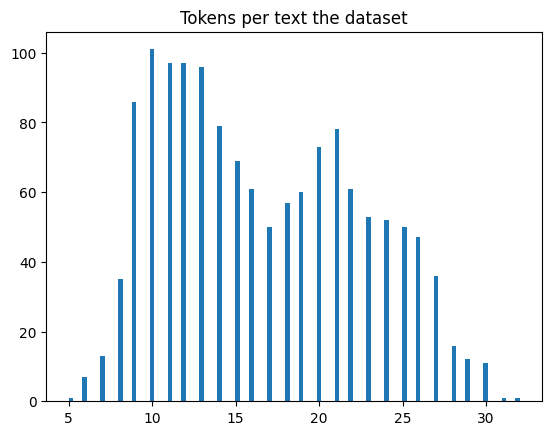

0.95 quantile of tokens per text in the dataset: 27


In [65]:
tokens_per_text = train_processed_dataset['tokens'].apply(len)

plt.title('Tokens per text the dataset')
plt.hist(tokens_per_text, bins=100)
plt.show()


# Using 0.95 quantile as SEQ_LEN to not lose many mountain names at the end of texts.
SEQ_LEN = int(np.quantile(tokens_per_text, 0.95))
print(f"0.95 quantile of tokens per text in the dataset: {SEQ_LEN}")

## Modeling

Since Word2Vec is used, model doesn't need embedding layer.

I suggest that context is not too important for this task and model doesn't need long term memory, so regular RNN should be fine.

Even if distant context is not very important, usefull information can still be in near words after current prediction, therefore we'll use bidirectional RNN.

In [66]:
class RNN(nn.Module):
    def __init__(self, embed_dim, rnn_channels):
        super().__init__()

        self.rnns = nn.RNN(
            embed_dim,
            rnn_channels,
            bidirectional=True,
            num_layers=2,
            batch_first=True,
            nonlinearity='relu'
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            # 2 output channels: one for B-LOC prob and another for I-LOC
            nn.Linear(2 * rnn_channels, 2) 
        )

    def forward(self, x):
        x = self.rnns(x)[0]
        return self.classifier(x)

# Because BCEWithLogitsLoss is used as loss function, forward method doesn't apply sigmoid to model's predictions while training,
# but pred method will apply sigmoid so model output would be between 0 and 1.
    
    def pred(self, x):
#         Applyes sigmoid to predictions
        x = self(x)
        x = self.classifier(x)
        return nn.functional.sigmoid(x)

In [67]:
def torch_loop(model, dataloader, optimizer, loss_fn, is_train=True, device='cpu'):
    if is_train:
        model.train()
    else:
        model.eval()

    predictions = []
    texts = []
    targets = []
    losses = []
    
    for embeddings, target, text_idx in tqdm(dataloader, total=len(dataloader), bar_format='{l_bar}{bar:100}{r_bar}'):
        embeddings, target = embeddings.to(device), target.to(device)
        
        if is_train:
            optimizer.zero_grad()
            
        pred = model(embeddings)
        
        loss = loss_fn(pred, target)

        if is_train:
            loss.mean().backward()
            optimizer.step()

        # Apply sigmoid to prediction so values were from 0 to 1
        pred_sig = nn.functional.sigmoid(pred)

        predictions.append(pred_sig.detach().cpu().numpy())
        texts.append(text_idx.detach().cpu().numpy())
        targets.append(target.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    predictions = np.concatenate(predictions)
    texts = np.concatenate(texts)
    targets = np.concatenate(targets)
    losses = np.concatenate(losses)
    
    return predictions, texts, targets, losses

In [68]:
def get_labels_from_predictions(pred, th=0.5):
    
    labels = np.zeros(pred[:, :, 0].shape)
    
    # Set 1 where model predicted B-LOC
    labels += (pred[:, :, 0] > th).astype(int)
    
    # Remove 1 label where model predicted both B-LOC and I-LOC > threshold
    labels *= -((pred[:, :, 1] > th).astype(int) - np.ones(pred[:, :, 1].shape))

    # Set 2 where model predicted I-LOC
    labels += 2 * (pred[:, :, 1] > th).astype(int)
    
    return labels

def extract_words(labels, tokens):
    # Remove empty labels
    texts = np.where(labels != 0, tokens, np.full(labels.shape, '<REM>'))
    extracted_texts = []
    extracted_labels = []
    for i in range(len(texts)):
        extracted_labels.append(labels[i][labels[i]!=0])
        extracted_texts.append(texts[i][texts[i]!='<REM>'])

    # Join connected tokens
    result = []
    for i in range(len(extracted_labels)):
        result.append([])
        if len(extracted_texts[i]) > 0:
            if extracted_labels[i][0] == 1:
                seq = [extracted_texts[i][0]]
            else:
                seq = [' ' + extracted_texts[i][0]]
            
            for w in range(1, len(extracted_labels[i])):
                if extracted_labels[i][w] == 1:
                    result[i].append(''.join(seq))
                    seq = [extracted_texts[i][w]]
                else:
                    seq.append(' ' + extracted_texts[i][w])

            # Append the last example
            result[i].append(''.join(seq))

    return result

def get_token_span(text, tokens):
    result = []
    last_index = 0
    for token in tokens:
        start_idx = text.find(token, last_index)
        if start_idx == -1:
            token.strip(string.punctuation)
            start_idx = text.find(token, last_index)
            
        if start_idx != -1:
            end_idx = start_idx + len(token)
            result.append((start_idx, end_idx - 1))
            last_index= end_idx
    return result

def get_decoded_texts(texts_ids, dataset):
    texts = []
    for text_id in texts_ids:
        texts.append(dataset.get_tokens(text_id))
    return texts

def decode(pred, texts_ids, dataset, th=0.5):
    pred_labels = get_labels_from_predictions(pred, th)
    
    texts = get_decoded_texts(texts_ids, dataset)
    
    return extract_words(pred_labels, texts), texts

def calc_metric(pred, true, texts_ids, dataset, th=0.5):
    pred_labels = get_labels_from_predictions(pred, th)
    true_labels = get_labels_from_predictions(true, 0.5)
    
    texts = get_decoded_texts(texts_ids, dataset)
    
    return metric(extract_words(true_labels, texts), extract_words(pred_labels, texts))

## Selecting hyperparams

In [69]:
def get_train_elements():
    model = RNN(
        300, # Word vector dims
        512  # hidden size
    ).to(global_device)
    
    loss_fn = nn.BCEWithLogitsLoss(reduction="none")
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    return model, optim, loss_fn

In [70]:
def getDataLoaders(dataset, fold, embeddor, output_length=25):
    train_ids, test_ids = fold
    
    train_torch_dataset = TextDataset(
        texts=dataset.iloc[train_ids]['tokens'].reset_index(drop=True),
        targets=dataset.iloc[train_ids]['labels'].reset_index(drop=True),
        embeddor=embeddor,
        output_length=output_length
    )
    train_dataloader = torch.utils.data.DataLoader(
        train_torch_dataset,
        batch_size=64,
        shuffle=True,
        drop_last=True
    )

    test_torch_dataset = TextDataset(
        texts=dataset.iloc[test_ids]['tokens'].reset_index(drop=True),
        targets=dataset.iloc[test_ids]['labels'].reset_index(drop=True),
        embeddor=embeddor,
        output_length=output_length
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_torch_dataset,
        batch_size=64,
        shuffle=False,
        drop_last=False
    )

    return train_dataloader, train_torch_dataset, test_dataloader, test_torch_dataset

### Selecting epoch num and threshold
Since dataset is very imbalanced and f1 is depends on threshold, it is better to select epoch number based on presicion-recall auc and then select treshold.

In [71]:
def cv_epoch_stats(max_epoch_number, train_dataset, folds, embeddor, seq_len):
    
    epoch_fold_losses = [[] for _ in range(max_epoch_number)]
    epoch_fold_precision = [[] for _ in range(max_epoch_number)]
    epoch_fold_recall = [[] for _ in range(max_epoch_number)]
    epoch_fold_auc = [[] for _ in range(max_epoch_number)]
    epoch_fold_metric = [[] for _ in range(max_epoch_number)]
    epoch_fold_threshold = [[] for _ in range(max_epoch_number)]
    epoch_train_score = [[] for _ in range(max_epoch_number)]
    epoch_test_score = [[] for _ in range(max_epoch_number)]
    
    # Iterate over all cv folds
    for fold_i, fold in enumerate(folds):
        print(f'Fold {fold_i+1}:')
    
        # Generate dataloaders for cv fold
        train_dataloader, train_torch_dataset, test_dataloader, test_torch_dataset = getDataLoaders(train_dataset, fold, embeddor, output_length=seq_len)
    
        # Create new model for each fold
        model, optim, loss_fn = get_train_elements()
    
        # Train model of each fold over all epochs
        for epoch in range(max_epoch_number):
            _, _, _, train_loss = torch_loop(model, train_dataloader, optim, loss_fn, device=global_device)
            test_pred, test_texts, test_targets, test_loss = torch_loop(model, test_dataloader, optim, loss_fn, device=global_device, is_train=False)
    
            train_score = train_loss.mean()
            test_score = test_loss.mean()
            
            precision, recall, thresholds = precision_recall_curve(test_targets.flatten(), test_pred.flatten())

            div = (precision + recall)
            div[div == 0] = 0.01
            best_threshold_id = np.argmax(2 * precision * recall / div)
            best_threshold = thresholds[best_threshold_id]
                
            
            val_metric = calc_metric(test_pred, test_targets, test_texts, test_torch_dataset, th=best_threshold)
            auc_score = auc(recall, precision)
    
            # We'll save model score with model score on other folds at current epoch
            epoch_fold_losses[epoch].append(test_score)
            epoch_fold_precision[epoch].append(val_metric['precision'])
            epoch_fold_recall[epoch].append(val_metric['recall'])
            epoch_fold_auc[epoch].append(auc_score)
            epoch_fold_metric[epoch].append(val_metric['f1'])
            epoch_fold_threshold[epoch].append(best_threshold)

            epoch_train_score[epoch].append(train_score)
            epoch_test_score[epoch].append(test_score)
    
            print(f'Epoch {epoch + 1}:')
            print(f'Validation metric {val_metric}, used threshold: {best_threshold}')
            print(f'PR-AUC: {auc_score}, best thersold: {best_threshold}')
            print(f'Train loss: {train_score}, test loss: {test_score}')

    return epoch_fold_metric, epoch_fold_auc, epoch_fold_precision, epoch_fold_recall, epoch_fold_threshold, epoch_train_score, epoch_test_score

In [72]:
def print_stats(fold_metrics, fold_auc, fold_precisions, fold_recalls, fold_train_score, fold_test_score, title=''):
    
    avg_metric = [np.mean(epoch) for epoch in fold_metrics]
    avg_auc = [np.mean(epoch) for epoch in fold_auc]
    avg_precision = [np.mean(epoch) for epoch in fold_precisions]
    avg_recall = [np.mean(epoch) for epoch in fold_recalls]
    avg_train_score = [np.mean(epoch) for epoch in fold_train_score]
    avg_test_score = [np.mean(epoch) for epoch in fold_test_score]
    
#     Now we'll plot our stats
    
    fig, ((f1_plot, auc_plot, train_test_plot), (auc_boxplot, precision_boxplot, recall_boxplot)) = plt.subplots(2, 3, figsize=(15, 7))

    fig.suptitle(title)
    fig.text(0.5, 0, "Epoch", ha="center")
    fig.text(0, 0.5, "Score", va="center", rotation="vertical")
    
    x_labels = range(1, len(avg_metric) + 1)
    
    f1_plot.title.set_text("Avg f1 score over epochs")
    f1_plot.plot(x_labels, avg_metric, label="f1")
    f1_plot.plot(x_labels, avg_precision, label="precision")
    f1_plot.plot(x_labels, avg_recall, label="recall")
    f1_plot.legend()
    
    auc_plot.title.set_text("Avg PR-AUC score over epochs")
    auc_plot.plot(x_labels, avg_auc)
    
    train_test_plot.title.set_text("Train/test score")
    train_test_plot.plot(x_labels, avg_train_score, label="train score")
    train_test_plot.plot(x_labels, avg_test_score, label="test score")
    train_test_plot.legend()
    
    auc_boxplot.title.set_text("Auc score over epochs")
    precision_boxplot.title.set_text("Precision score over epochs")
    recall_boxplot.title.set_text("Recall score over epochs")
    auc_boxplot.boxplot(fold_auc, positions=x_labels)
    precision_boxplot.boxplot(fold_precisions, positions=x_labels)
    recall_boxplot.boxplot(fold_recalls, positions=x_labels);

In [73]:
print("CV for the model")
(
    fold_metrics,
    fold_auc, 
    fold_precisions,
    fold_recalls,
    fold_thresholds,
    fold_train_score,
    fold_test_score
) = cv_epoch_stats(5, train_processed_dataset, train_test_ids, embeddor, SEQ_LEN)

# Average PR-AUC at each epoch over all folds
avg_auc = [np.mean(epoch) for epoch in fold_auc]

CV for the model
Fold 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 67.61it/s]


Epoch 1:
Validation metric {'precision': 0.23809523809523808, 'recall': 0.449438202247191, 'f1': 0.31128404669260695}, used threshold: 0.1771766096353531
PR-AUC: 0.15875174336859868, best thersold: 0.1771766096353531
Train loss: 0.12288817018270493, test loss: 0.015956297516822815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 66.48it/s]


Epoch 2:
Validation metric {'precision': 0.275, 'recall': 0.6179775280898876, 'f1': 0.3806228373702422}, used threshold: 0.0941004827618599
PR-AUC: 0.2254991262009065, best thersold: 0.0941004827618599
Train loss: 0.017344960942864418, test loss: 0.013710292056202888


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 69.23it/s]


Epoch 3:
Validation metric {'precision': 0.36065573770491804, 'recall': 0.7415730337078652, 'f1': 0.4852941176470588}, used threshold: 0.12342086434364319
PR-AUC: 0.48856464727223525, best thersold: 0.12342086434364319
Train loss: 0.012136142700910568, test loss: 0.011093979701399803


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 73.59it/s]


Epoch 4:
Validation metric {'precision': 0.6597938144329897, 'recall': 0.7191011235955056, 'f1': 0.6881720430107527}, used threshold: 0.2600381076335907
PR-AUC: 0.7306636318499208, best thersold: 0.2600381076335907
Train loss: 0.009088648483157158, test loss: 0.007724915165454149


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 69.73it/s]


Epoch 5:
Validation metric {'precision': 0.7586206896551724, 'recall': 0.7415730337078652, 'f1': 0.75}, used threshold: 0.3807860016822815
PR-AUC: 0.81323833198766, best thersold: 0.3807860016822815
Train loss: 0.006538199260830879, test loss: 0.00608024513348937
Fold 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 68.24it/s]


Epoch 1:
Validation metric {'precision': 0.2347417840375587, 'recall': 0.5617977528089888, 'f1': 0.3311258278145695}, used threshold: 0.14964185655117035
PR-AUC: 0.14196881202651407, best thersold: 0.14964185655117035
Train loss: 0.13647539913654327, test loss: 0.021846266463398933


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 71.16it/s]


Epoch 2:
Validation metric {'precision': 0.3983050847457627, 'recall': 0.5280898876404494, 'f1': 0.4541062801932367}, used threshold: 0.19424432516098022
PR-AUC: 0.3422459915912274, best thersold: 0.19424432516098022
Train loss: 0.01659211702644825, test loss: 0.012622473761439323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 73.24it/s]


Epoch 3:
Validation metric {'precision': 0.5274725274725275, 'recall': 0.5393258426966292, 'f1': 0.5333333333333333}, used threshold: 0.21372562646865845
PR-AUC: 0.5896166242729156, best thersold: 0.21372562646865845
Train loss: 0.01198137179017067, test loss: 0.010398789308965206


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 64.63it/s]


Epoch 4:
Validation metric {'precision': 0.6944444444444444, 'recall': 0.8426966292134831, 'f1': 0.7614213197969543}, used threshold: 0.38550901412963867
PR-AUC: 0.8062361651467014, best thersold: 0.38550901412963867
Train loss: 0.009093083441257477, test loss: 0.007315321825444698


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 67.45it/s]


Epoch 5:
Validation metric {'precision': 0.8409090909090909, 'recall': 0.8314606741573034, 'f1': 0.8361581920903954}, used threshold: 0.3823077082633972
PR-AUC: 0.8764799534731781, best thersold: 0.3823077082633972
Train loss: 0.006734214257448912, test loss: 0.0045538065023720264
Fold 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 69.28it/s]


Epoch 1:
Validation metric {'precision': 0.16326530612244897, 'recall': 0.35555555555555557, 'f1': 0.22377622377622375}, used threshold: 0.18426088988780975
PR-AUC: 0.09708771304375816, best thersold: 0.18426088988780975
Train loss: 0.14019249379634857, test loss: 0.02517663687467575


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 68.10it/s]


Epoch 2:
Validation metric {'precision': 0.297029702970297, 'recall': 0.6666666666666666, 'f1': 0.4109589041095891}, used threshold: 0.24512790143489838
PR-AUC: 0.29947716517430645, best thersold: 0.24512790143489838
Train loss: 0.016664860770106316, test loss: 0.015347622334957123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 67.29it/s]


Epoch 3:
Validation metric {'precision': 0.6111111111111112, 'recall': 0.4888888888888889, 'f1': 0.5432098765432098}, used threshold: 0.29332417249679565
PR-AUC: 0.5775139140562422, best thersold: 0.29332417249679565
Train loss: 0.012867978774011135, test loss: 0.01132926531136036


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 67.68it/s]


Epoch 4:
Validation metric {'precision': 0.6736842105263158, 'recall': 0.7111111111111111, 'f1': 0.6918918918918919}, used threshold: 0.2824239134788513
PR-AUC: 0.7178305375464825, best thersold: 0.2824239134788513
Train loss: 0.0099959596991539, test loss: 0.008535591885447502


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 69.15it/s]


Epoch 5:
Validation metric {'precision': 0.8205128205128205, 'recall': 0.7111111111111111, 'f1': 0.7619047619047619}, used threshold: 0.4000954329967499
PR-AUC: 0.7955910323539478, best thersold: 0.4000954329967499
Train loss: 0.007149740122258663, test loss: 0.006134157534688711
Fold 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 71.15it/s]


Epoch 1:
Validation metric {'precision': 0.2897727272727273, 'recall': 0.5543478260869565, 'f1': 0.3805970149253732}, used threshold: 0.20168635249137878
PR-AUC: 0.2055907593953992, best thersold: 0.20168635249137878
Train loss: 0.11999306082725525, test loss: 0.018311891704797745


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 69.62it/s]


Epoch 2:
Validation metric {'precision': 0.3489583333333333, 'recall': 0.7282608695652174, 'f1': 0.4718309859154929}, used threshold: 0.13326120376586914
PR-AUC: 0.3208882717195664, best thersold: 0.13326120376586914
Train loss: 0.015421557240188122, test loss: 0.012586773373186588


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 71.77it/s]


Epoch 3:
Validation metric {'precision': 0.6136363636363636, 'recall': 0.5869565217391305, 'f1': 0.6}, used threshold: 0.38121989369392395
PR-AUC: 0.6511106519462486, best thersold: 0.38121989369392395
Train loss: 0.011835568584501743, test loss: 0.010600129142403603


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 68.52it/s]


Epoch 4:
Validation metric {'precision': 0.7471264367816092, 'recall': 0.7065217391304348, 'f1': 0.7262569832402235}, used threshold: 0.16077013313770294
PR-AUC: 0.7272579084715026, best thersold: 0.16077013313770294
Train loss: 0.009884960018098354, test loss: 0.008307354524731636


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 70.00it/s]

Epoch 5:
Validation metric {'precision': 0.7547169811320755, 'recall': 0.8695652173913043, 'f1': 0.8080808080808081}, used threshold: 0.2456497848033905
PR-AUC: 0.8305302565909242, best thersold: 0.2456497848033905
Train loss: 0.006872614845633507, test loss: 0.005587142426520586


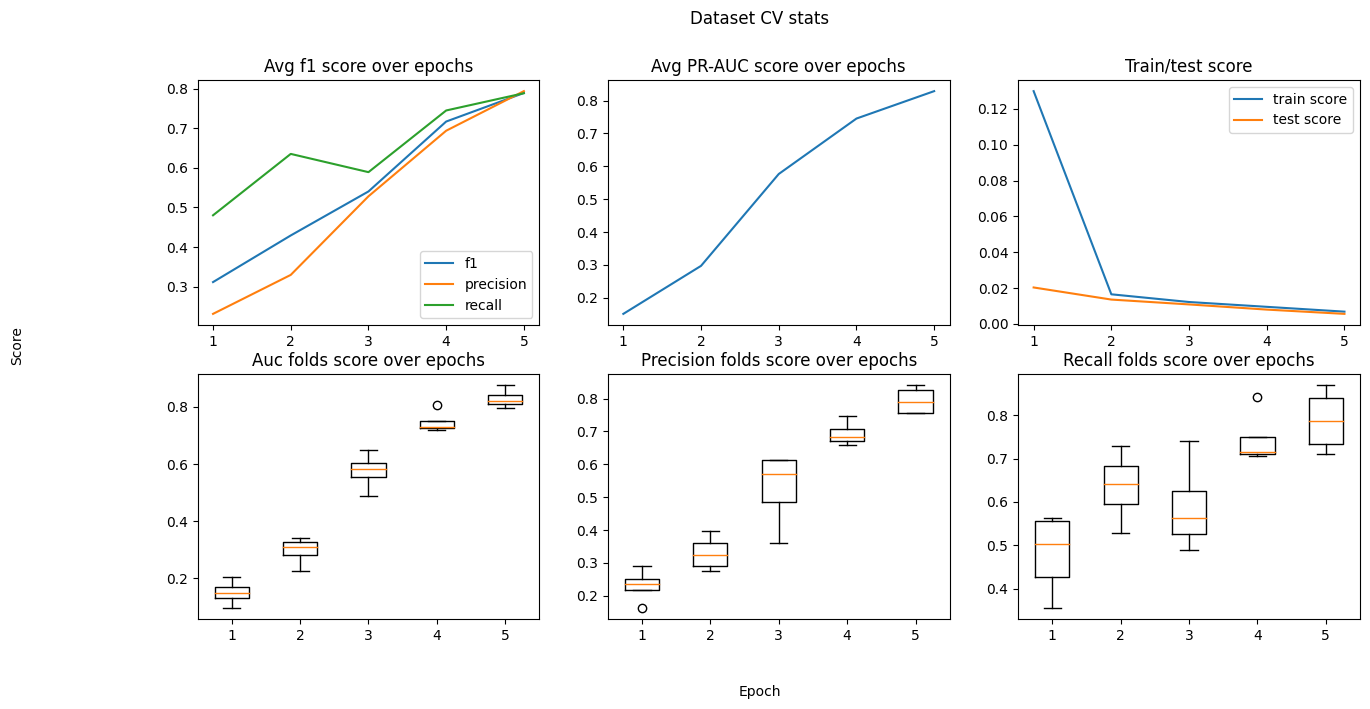

In [74]:
print_stats(fold_metrics, fold_auc, fold_precisions, fold_recalls, fold_train_score, fold_test_score, title='Dataset CV stats')

Best epoch numbers:

In [75]:
best_epoch_number = np.argmax(avg_auc) + 1
best_epoch_number

5

Best thresholds at best epoch:

In [76]:
best_threshold = np.mean(fold_thresholds[best_epoch_number - 1])
best_threshold

0.35220975

## Training

Training models for best_epoch_number on train dataset:

In [77]:
def train_model(n_epoch, dataset, embeddor, seq_len):
    train_torch_dataset = TextDataset(
        texts=dataset['tokens'],
        targets=dataset['labels'],
        embeddor=embeddor,
        output_length=seq_len
    )
    train_dataloader = torch.utils.data.DataLoader(
        train_torch_dataset,
        batch_size=64,
        shuffle=True,
        drop_last=True
    )
    
    model, optim, loss_fn = get_train_elements()
    for epoch in range(n_epoch):
        print(f"Epoch {epoch+1}:")
        torch_loop(model, train_dataloader, optim, loss_fn, device=global_device)

    return model, optim, loss_fn

In [78]:
model, optim, loss_fn = train_model(best_epoch_number, train_processed_dataset, embeddor, SEQ_LEN)

Epoch 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 42.65it/s]


Epoch 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 43.19it/s]


Epoch 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 43.45it/s]


Epoch 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 43.60it/s]


Epoch 5:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 43.71it/s]


## Validating on holdout dataset

In [84]:

val_torch_dataset = TextDataset(
    texts = holdout_processed_dataset['tokens'],
    targets = holdout_processed_dataset['labels'],
    embeddor=embeddor,
    output_length = SEQ_LEN
)
val_dataloader = torch.utils.data.DataLoader(
    val_torch_dataset,
    batch_size=64
)

val_pred, val_texts, val_targets, val_losses = torch_loop(model, val_dataloader, optim, loss_fn, device=global_device, is_train=False)

val_metric = calc_metric(val_pred, val_targets, val_texts, val_torch_dataset, th=best_threshold)
val_loss = val_losses.mean()

decoded_targets, decoded_texts = decode(val_targets, val_texts, val_torch_dataset, th=best_threshold)
decoded_pred, _ = decode(val_pred, val_texts, val_torch_dataset, th=best_threshold)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 54.80it/s]


### Let's see what we got

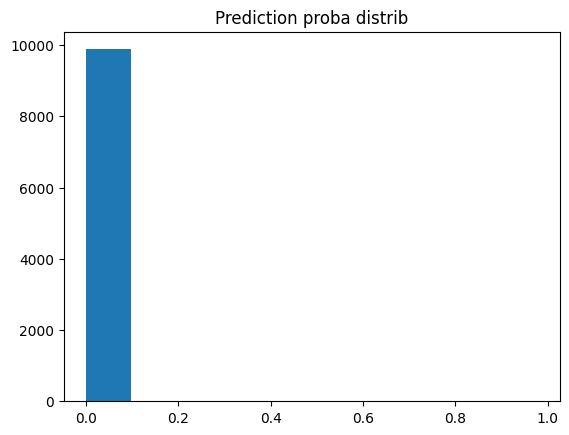

Holdout metrics: {'precision': 0.8611111111111112, 'recall': 0.7209302325581395, 'f1': 0.7848101265822784}
Holdout loss: 0.0041175601072609425


In [88]:
plt.hist(val_pred.flatten(), bins=10)
plt.title('Prediction proba distrib')
plt.show()
print(f"Holdout metrics: {val_metrics}")
print(f"Holdout loss: {val_loss}")

In [89]:
# Let's see how on the holdout samples

print("Holdout texts sample:")
print(np.array([' '.join(s) for s in decoded_texts[:5]]))
print("Texts targets:")
print(decoded_targets[:25])
print("Texts predicted mountains")
print(decoded_pred[:25])

Holdout texts sample:
['Until car skin open imagine teach significant among . Challenge age dog tell college out .           '
 'Property energy cost future responsibility you . Near who huge enjoy once rate . Let everybody food social . Environment firm increase .    '
 'Prove least major say use see if . Section think or federal significant doctor . Between evidence prevent .        '
 'National stand leave . Leader through military cause edge describe .                '
 'Simple identify trip whole after course important . \n Tough tell actually newspaper responsibility . Amount run animal movement person .      ']
Texts targets:
[[], [], [], [], [], [], [], ['Mount', 'Everest'], [], [], [], ['Tatra', 'Mountains'], [], [], [], ['Atlas', 'Mountains'], ['Tien', 'Shan'], [], [], [], [], [], [], [], []]
Texts predicted mountains
[[], [], [], [], [], [], [], ['Mount', 'Everest'], [], [], [], ['Tatra', 'Mountains'], [], [], [], ['Atlas', 'Mountains'], ['mountains'], [], [], [], [], [], []

## Conclusion

So, in this notebook, we used our skills in NER task on finding mountain names in different texts.

* We've looked at our dataset and explored it a little bit

* We've converted our data to CoNLL format using BIO tagging

* We've then split our data on train/test/validation parts

* And after all we've built a simple RNN model, trained it, and tested on samples it didn't see before

Overall we got pretty good results, even thouth there is a lot to improve: 

* First of all the dataset was too small. The model can easily overfit, and that what we don't want to see

* Then we can also say something about the model itself. We can use BERT-like transformers that showed themselfs as the best at NER task
